## Value-at-Risk (VaR) Modeling for an S&P 500 Portfolio


$\textbf{Project Description:}$
This project aimed at quantifying the potential losses of a portfolio representing the S&P 500 index through three different methodologies for calculating Value-at-Risk (VaR). The holding period for the portfolio was set at 4 days, offering a short-term risk perspective.

$\textbf{Historical Simulation:}$
The first approach utilized was the Historical Simulation method. In this method, the historical returns of the portfolio were used to simulate potential future returns. By analyzing the past performance of the portfolio, the worst-case scenarios that could occur over the specified holding period were identified. This method provides a non-parametric estimate of VaR and is known for its simplicity and ease of interpretation.

$\textbf{BRW Method:}$
The second approach taken was introduced by Boudoukh, Richardson, and Whitelaw (1998). This method is a generalization of the historical simulation method, where returns are not assumed to be identically and independently distributed (i.i.d.). It assigns higher probability weights to returns from the recent past, using an exponential decay factor lambda (between 0 and 1). VaR is then calculated based on the empirical cumulative distribution function (CDF) of returns with these modified probability weights.

$\textbf{Filtered Historical Simulation using GARCH:}$
The final approach was the Filtered Historical Simulation using the Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model. The GARCH model was used to estimate the volatility of the portfolio returns over time. By using the GARCH model, the project was able to incorporate the time-varying nature of volatility into the VaR estimation. This method combines the advantages of the historical simulation method with the ability to capture the conditional heteroskedasticity in the data.

$\textbf{Conclusion:}$
This project provided a comprehensive assessment of the potential losses in an S&P 500 portfolio through three different VaR estimation methodologies - Historical Simulation, BRW, and Filtered Historical Simulation using GARCH. The different approaches allowed for a robust comparison of risk measures and an understanding of the strengths and limitations of each method. Based on the results of the Christoffersen test and the Kupiec test, the Filtered Historical Simulation using GARCH was identified as the best method among the three. This method demonstrated the most accurate and reliable VaR estimates, thereby making it the preferred choice for estimating the potential losses in the S&P 500 portfolio.

### 0. Packages 

In [41]:
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt 
from scipy.stats import chi2, norm
from arch import arch_model
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from scipy.stats import binomtest


### 1. Data

In [42]:
# Get daily data MSCI 
df = yf.download('^GSPC','1984-01-01','2022-01-09',interval='1d')

# Keep Closing price and compute returns  
df['returns'] = df.Close.pct_change()
df = df.dropna()

# Define returns df and convert into serie 
ret = df.returns.squeeze()

# Rebalancing every 4 days
ret = ret.resample('4D').last()
ret = ret.dropna()
ret 


[*********************100%%**********************]  1 of 1 completed


Date
1984-01-04    0.002784
1984-01-08   -0.000893
1984-01-12   -0.004352
1984-01-16   -0.003044
1984-01-20   -0.008062
                ...   
2021-12-19    0.010180
2021-12-23    0.006224
2021-12-27   -0.002990
2021-12-31    0.006374
2022-01-04   -0.004050
Name: returns, Length: 3468, dtype: float64

/Users/lambnjo/opt/anaconda3/envs/vola/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lambnjo/opt/anaconda3/envs/vola/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


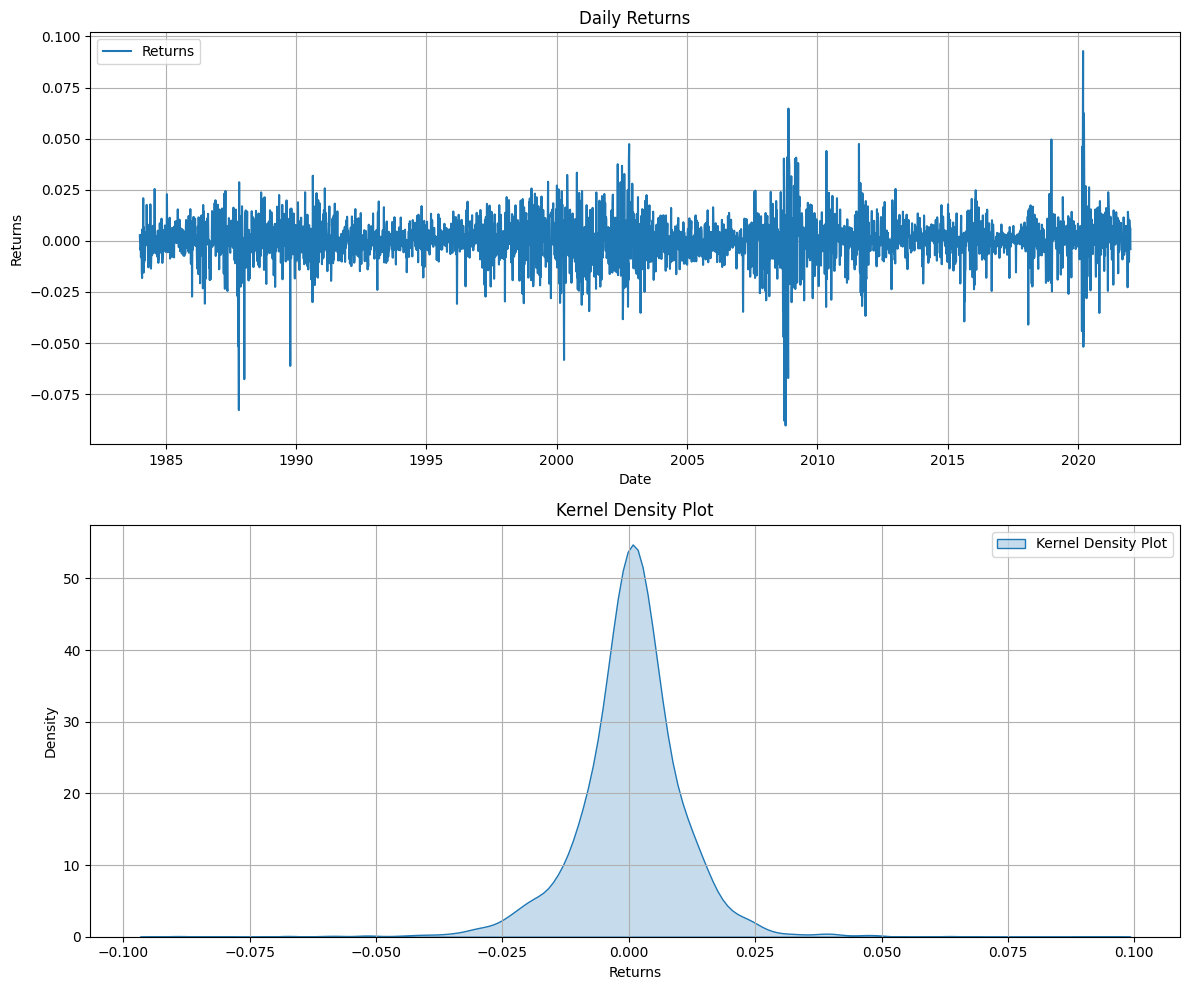

In [43]:
# Create a single figure with two subplots arranged vertically
fig, axes = plt.subplots(2, 1, figsize=(12, 10))  

# Plot the daily returns in the first subplot
axes[0].plot(ret.index, ret, label='Returns')
axes[0].set_title('Daily Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')
axes[0].grid(True)
axes[0].legend()

# Plot the kernel density in the second subplot
sns.kdeplot(ret, fill=True, label='Kernel Density Plot', ax=axes[1])
axes[1].set_title('Kernel Density Plot')
axes[1].set_xlabel('Returns')
axes[1].set_ylabel('Density')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()  # Ensures that the plots don't overlap
plt.show()

### 2. VaR using Historical Simulation

In [44]:
# Parameters 
rolling_window = 65 # Number of days for the rolling window 
condifend_level = 0.99

# Initialize list to store VaR values 
rolling_var = []

# Loop to get rolling simulation  
for t in range(rolling_window, len(ret)):
    # Select the rolling window returns  
    returns = ret.iloc[t - rolling_window : t]
  
    # Calculate VaR for the window at the specified confidence level
    var = np.percentile(returns, 100 * (1 - condifend_level))
    
    # Store the VaR estimate for this time step
    rolling_var.append(var)

# Create a Serie to store rolling VaR 
var_hs = pd.Series(data=rolling_var,index=ret.index[rolling_window:],name='VaR')


### 3. VaR using BRW (Boudoukh, Richardson, and Whitelaw)
Let $r_{t}$ denote the return of the day $t$ and let $N$ be the rolling window of size of 65 days. The weight of the return from $n$ days ago, $w_{n}$, within the rolling window is calculated as : 
- $w_{n} = \lambda ^{N-n}$ 
- $w_{n} = \frac{w_{n}}{\sum_{i=1}^{N}}$ After calculating the weights, they are normalized
- $w_{n} = max(w_{n},minweight)$ Avoid having weights equal to zero 

In [45]:
# Define parameters
rolling_window_size = 65  # Number of days for the rolling window
confidence_level = 0.99
decay_factor = 0.94  # Exponential decay factor (λ)
min_weight = 1e-4  # Minimum weight threshold

# Initialize an empty list to store VaR estimates
rolling_var = []

# Rolling window loop
for t in range(rolling_window_size, len(ret)):
    # Select data within the rolling window
    returns = ret.iloc[t - rolling_window_size: t]

    # Calculate exponentially weighted probability weights
    weights = np.array([(decay_factor ** i) for i in range(1, len(returns) + 1)])
    
    # Apply a minimum weight threshold
    weights = np.array([max(weight, min_weight) for weight in weights])
    weights /= sum(weights)  # Normalize weights
    
    # Calculate VaR for the window at the specified confidence level using weighted percentiles
    var = stats.mstats.mquantiles(returns, prob=1 - confidence_level, alphap=weights, betap=1-weights)
    
    # Store the VaR estimate for this time step
    rolling_var.append(var[0])

# Convert the rolling VaR estimates to a DataFrame with corresponding dates
var_brw = pd.Series(data=rolling_var,index=ret.index[rolling_window_size:],name='VaR_Brew')




### 4. Filtered Historical Simulation VaR using GARCH

- $\sigma^{2}_{t,GARCH} = \omega + \alpha \epsilon^{2}_{t-1} + \beta \sigma^{2}_{t-1}$

- $r_{t}^{Filtered Volatility} = r_{t}  \frac {\sigma_{t+1,GARCH}} {\sigma_{t,GARCH}}$

In [46]:
# Initialize a DataFrame to store the computations
df = pd.DataFrame(data=None,index=ret.index)

# Rescale the original data convergence purposes 
rescaling_factor = 100
rescaled_ret = ret * rescaling_factor

# Fit an ARMA model
arma_model = arch_model(rescaled_ret, vol='Constant', p=1, q=1)
res_arma = arma_model.fit(disp='off')
df['residual'] = res_arma.resid

# Fit a GARCH(1,1) model to the residuals
garch_model = arch_model(df['residual'], vol='Garch', p=1, q=1)
garch_results = garch_model.fit(disp='off')

# Transform the conditional volatility estimates to the original scale
df['devol_vola'] = (garch_results.conditional_volatility) * 1/100

# Drop the residual column
df = df.drop('residual', axis=1)

# Shift the devol vola computed to get the devol 
df['revol_vola'] = df.devol_vola.copy().shift(-1)

# Compute the scale vola  
df['scaled_vola'] = df.revol_vola / df.devol_vola

# Create a new Serie of returns 
ret_sc = df.scaled_vola.copy() * ret.copy()
ret_sc.name = 'Returns_Scaled'



In [47]:
# Parameters 
rolling_window = 65 # Number of the days in the rolling window 
condifend_level = 0.99

# Initialize list to store VaR values 
rolling_var = []

# Loop to get rolling simulation  
for t in range(rolling_window, len(ret_sc)):
    # Select the rolling window returns  
    returns = ret_sc.iloc[t - rolling_window : t]
  
    # Calculate VaR for the window at the specified confidence level
    var = np.percentile(returns, 100 * (1 - confidence_level))
    
    # Store the VaR estimate for this time step
    rolling_var.append(var)

# Create a Serie to store rolling VaR 
var_fh = pd.Series(data=rolling_var,index=ret.index[rolling_window:],name='VaR')


### 5. Plot VaR  

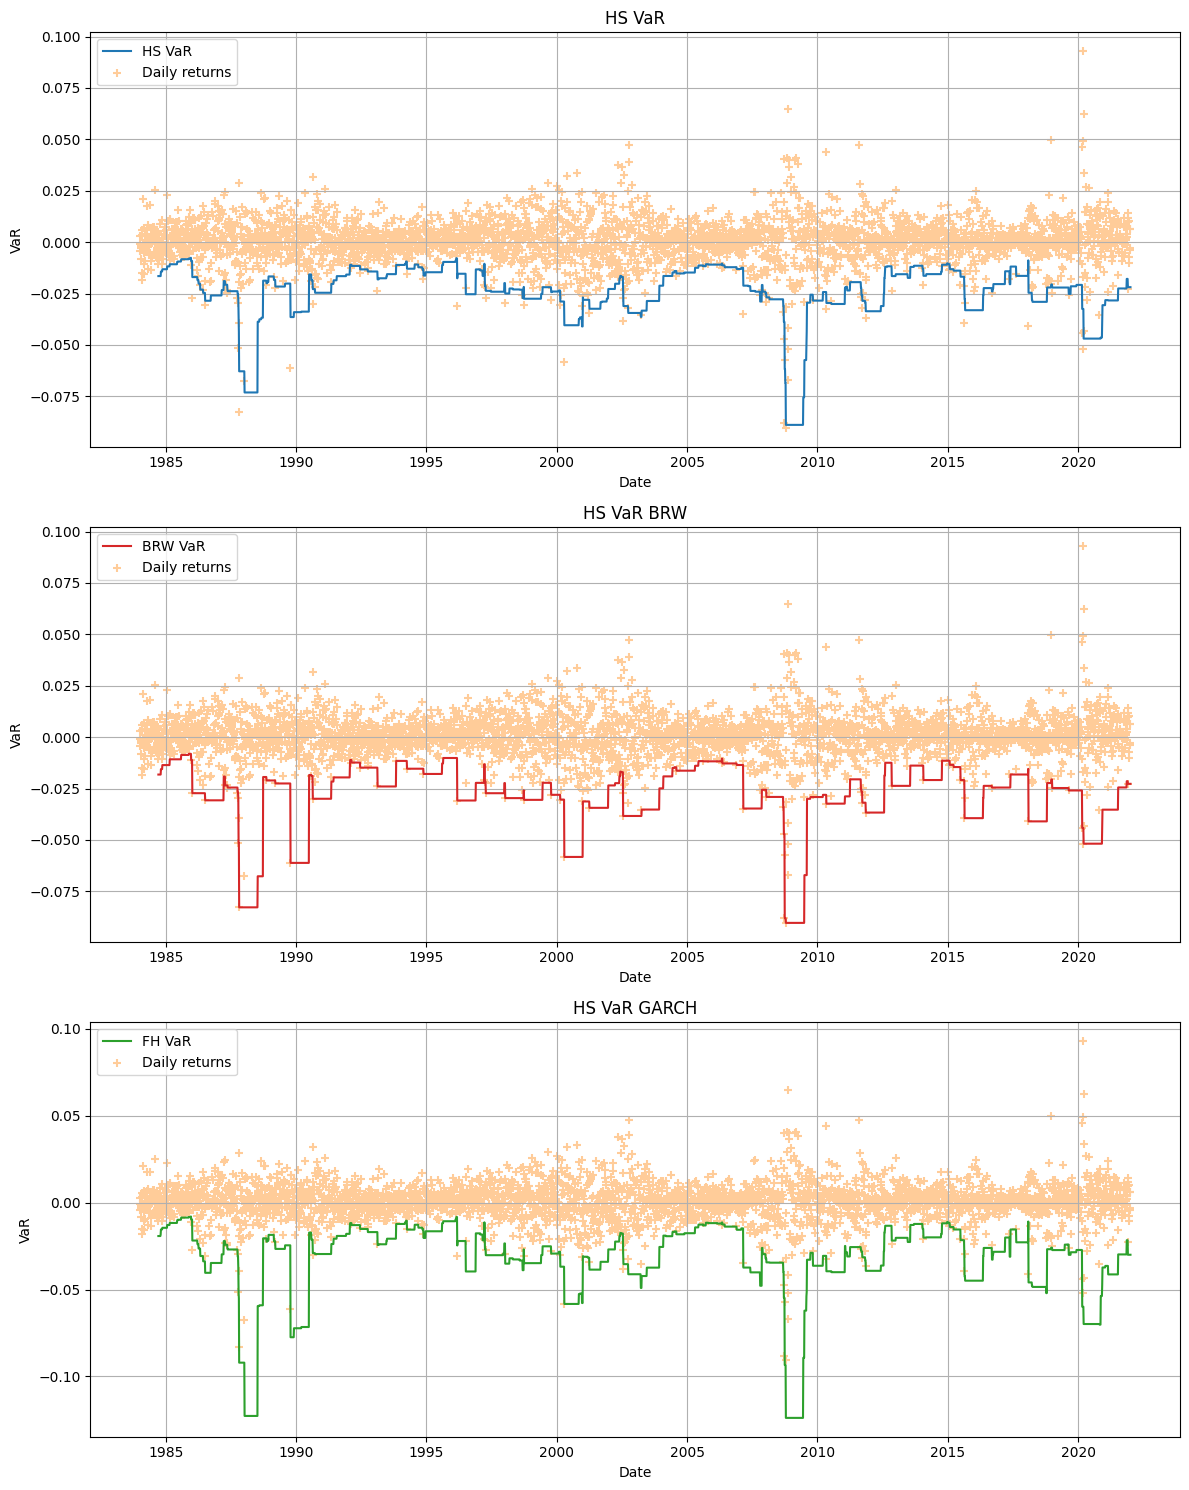

In [49]:
# Plot the Historical VaR and returns over a given period 
start = '1984-01-04 ' # Modify the starting date 
end = '2023-12-01' # Modify the ending date 

# Select the corresponding period in both series 
var_brw_p = var_brw.loc[start:end]
var_p = var_hs.loc[start:end]
var_fh_p = var_fh.loc[start:end]
ret_p = ret.loc[start:end]


# Adjust the lightness by modifying the RGB values
lighter_color = (1.0, 0.8, 0.6)  # A lighter shade of red (increase the G and B components)

# Create a single figure with three subplots arranged vertically
fig, axes = plt.subplots(3, 1, figsize=(12, 15))  # 3 rows, 1 column

# Plot the first subplot
axes[0].plot(var_p.index, var_p, label='HS VaR', color='C0')
axes[0].scatter(ret_p.index,ret_p,label='Daily returns',color=lighter_color,marker='+')
axes[0].grid(True)
axes[0].set_title('HS VaR')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('VaR')
axes[0].legend()

# Plot the second subplot
axes[1].plot(var_brw_p.index, var_brw_p, label='BRW VaR', color='C3')
axes[1].scatter(ret_p.index,ret_p,label='Daily returns',color=lighter_color,marker='+')
axes[1].grid(True)
axes[1].set_title('HS VaR BRW')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('VaR')
axes[1].legend()


# Plot the third subplot
axes[2].plot(var_fh_p.index, var_fh_p, label='FH VaR', color='C2')
axes[2].scatter(ret_p.index,ret_p,label='Daily returns',color=lighter_color,marker='+')
axes[2].grid(True)
axes[2].set_title('HS VaR GARCH')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('VaR')
axes[2].legend()

plt.tight_layout()  # Ensures that the plots don't overlap
plt.show()

### 6. Christophersen & Kupiec Tests 

In [51]:
def CH(alpha,returns,var_values):

    # Reindex returns with var values
    returns = returns.loc[var_values.index[0]:]
    
    # Convert the df into series 
    returns = returns.shift(-1)
   
    # Step 1: Identify VaR Exceedances
    exceedances = returns < var_values

    # Step 2: Unconditional Coverage Test
    actual_exceedances = exceedances.sum()
    expected_exceedances = len(returns) * alpha
    
    # Calculate the chi-squared test statistic
    chi_squared = np.sum((actual_exceedances - expected_exceedances) ** 2 / expected_exceedances)
    
    # Set the degrees of freedom for the chi-squared test
    degrees_of_freedom = 1  # For a binary outcome (exceedance or not)
    
    # Calculate the p-value for the chi-squared test
    p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)
    
    return [actual_exceedances,expected_exceedances,chi_squared,p_value]

def Kupiec(alpha,returns,var_estimates):
    
    # Reindex returns with var values
    actual_returns = returns.loc[var_estimates.index[0]:]
    
    # Convert the df into series 
    actual_returns = actual_returns.shift(-1)
    
    # Calculate the number of observations
    n_observations = len(actual_returns)
    
    # Calculate the number of VaR violations
    violations = np.sum(actual_returns < var_estimates)
    
    # Calculate the expected number of violations based on the confidence level
    expected_violations = n_observations * alpha
    
    # Perform the Kupiec Test using the binomial test
    results = binomtest(violations, n_observations, alpha)

    return [violations,expected_violations,results.statistic,results.pvalue]

# Set the significance level for the test
alpha = 0.01

# Create df to store the uncond test values 
df_test = pd.DataFrame(data=None,
                         columns=['HS','BRW','FH'],
                         index=['Exceedances','Expected Exceedances','Critical value','p value'])

# Compute the uncond test values 
df_test.HS = CH(alpha,ret,var_hs)
df_test.BRW = CH(alpha,ret,var_brw)
df_test.FH = CH(alpha,ret,var_fh)

# Create df to store the uncond test values 
df_test2 = pd.DataFrame(data=None,
                         columns=['HS','BRW','FH'],
                         index=['Exceedances','Expected Exceedances','Critical value','p value'])


# Compute the uncond test values 
df_test2.HS = Kupiec(alpha,ret,var_hs)
df_test2.BRW = Kupiec(alpha,ret,var_brw)
df_test2.FH = Kupiec(alpha,ret,var_fh)

# Get both test into one df 
df = pd.concat([df_test,df_test2],axis=0,keys=['Christophsen Test','Kupiec Test'],join='outer')

# Round the results 
df = df.round(3)
df

HS     BRW      FH
Christophsen Test Exceedances           85.000  62.000  48.000
                  Expected Exceedances  34.030  34.030  34.030
                  Critical value        76.343  22.989   5.735
                  p value                0.000   0.000   0.017
Kupiec Test       Exceedances           85.000  62.000  48.000
                  Expected Exceedances  34.030  34.030  34.030
                  Critical value         0.025   0.018   0.014
                  p value                0.000   0.000   0.020